# [Karate] 2nd order LINE implementation with Negative Sampling

## 1. Import Dataset & Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

#### 1) make graph ( undirected -> directed)

In [2]:
edge = pd.read_csv('karate_club.edgelist', sep=' ', names=['x','y','w'])
edge['w']=1 # unweighted graph

In [3]:
graph = nx.Graph()
for i in range(edge.shape[0]):
    graph.add_node(node_for_adding = edge['x'][i])
    graph.add_node(node_for_adding = edge['y'][i])
    graph.add_edge(edge['x'][i], edge['y'][i])

In [4]:
# make it as directed graph
reverse_edge = edge[['y','x','w']]
reverse_edge.columns = ['x','y','w']

total_edge = pd.concat([edge,reverse_edge])
total_edge = np.array(total_edge)
np.random.shuffle(total_edge)

#### 2) adjacent matrix & one-hot encoded matrix

In [5]:
A = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes()))
OH = np.identity(A.shape[0])

In [6]:
OH = np.identity(A.shape[0])

## 2. Define Functions

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.00001))

In [8]:
# get two nodes from one edge
def node_from_edge(edges):
    random_idx = np.random.choice(edges.shape[0],1)
    edge = edges[random_idx][0]
    return edge[0],edge[1]

In [9]:
degree = np.array(A.sum(axis=1).flatten())

In [10]:
def get_neg(idx,n):
    unconnected = np.where(A[idx]==0)[1]    
    unconnected_degree = degree[0][unconnected]
    unconnected_weight = unconnected_degree / unconnected_degree.sum()
    return np.random.choice(unconnected, n, p=unconnected_weight)

## 3. Second-order Proximity with Negative Sampling

In [11]:
def second_order_neg_sam(num_neg,epoch,lr,dim):
    
    context_vector = np.random.rand(OH.shape[0],2)
    itself_vector = np.random.rand(OH.shape[0],2)
    
    for _ in range(epoch): # epoch
        for edge in total_edge:
            start,end = edge[0],edge[1]

            start_context,start_itself = context_vector[start], itself_vector[start]
            end_context,end_itself = context_vector[end], itself_vector[end]        

            EH = np.zeros(dim)
            
            pos_case = sigmoid(np.dot(context_vector[end],itself_vector[start]))-1
            EH += pos_case*context_vector[end]
            context_vector[end] -= lr*pos_case*itself_vector[start] # 1) Context / Pos
                        
            neg_samples = get_neg(start,num_neg)
            
            for neg in neg_samples:
                neg_case = sigmoid(np.dot(context_vector[neg],itself_vector[start]))-0
                EH += neg_case*context_vector[neg]
                context_vector[neg] -= lr*neg_case*itself_vector[start] # 2) Context / Neg 
            
            itself_vector[start] -= lr*EH # 3) Itself / target
            
    return context_vector, itself_vector

In [12]:
con,it = second_order_neg_sam(5,20,0.1,2)

## 4. Visualization

In [13]:
Emb_df = pd.DataFrame({'X':it[:,0], 'Y':it[:,1],'Label':range(1,35)})

blue = [1,2,3,4,5,6,7,8,9,11,12,13,14,17,18,20,22]
red = list(set(range(0,35))-set(blue))

Emb_df.loc[Emb_df.Label.isin(blue),'Color']=1
Emb_df.loc[Emb_df.Label.isin(red),'Color']=0

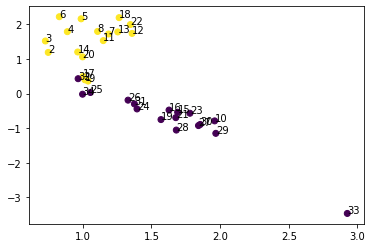

In [14]:
plt.scatter(Emb_df['X'], Emb_df['Y'], c=Emb_df['Color'])

for i,txt in enumerate(Emb_df['Label']):
    plt.annotate(txt, (Emb_df['X'][i], Emb_df['Y'][i]))